In [1]:
import csv
import os
import tensorflow as tf
import numpy as np
import random
import re

from bs4 import BeautifulSoup
from collections import namedtuple

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [ ]:
DATA_DIR=os.path.abspath('../data')
MODEL_DIR=os.path.abspath('../models')
NLTK_DIR=MODEL_DIR + '/nltk_data'

os.environ['NLTK_DATA']=NLTK_DIR

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords', download_dir=NLTK_DIR)
nltk.download('punkt', download_dir=NLTK_DIR)

In [14]:
unlabeled_issues = []
issues = []

Issue = namedtuple('Issue', ['text', 'labels'])

stop_words = set(stopwords.words('english'))
print("stop word count: %d" % len(stop_words))

def strip_spaces(x):
    return re.sub(" ", "", x)

def is_group_label(label):
    if label == 'Engineering Productivity':
      return True

    if label.find('group::') == 0 and label.lower().find('deprecated') < 0 and label.find('not_owned') < 0:
      return True

    return False

def load_csv(filename, output):
    with open(filename) as file:
        count = 0
        csv.field_size_limit(10 * 1024 * 1024)
        data = csv.DictReader(file)

        for line in data:
            issue_labels = line['Labels']
            parsed_labels = issue_labels.split(',')
            issue_labels = [strip_spaces(x) for x in parsed_labels]
            filtered_labels = [x for x in issue_labels if x.find('devops::') >= 0]
            
            if 'automation:ml' in parsed_labels and 'automation:ml wrong' not in parsed_labels:
                continue
            
            issue_text = "%s\n%s" % (line['Title'], line['Description'])
            
            # Workaround for https://bugs.python.org/issue34480
            try:
                issue_text = BeautifulSoup(issue_text).get_text()
            except (UnboundLocalError, TypeError) as e:
                print("ignoring issue with bad HTML: %s" % e)
                continue
                          
            word_tokens = word_tokenize(issue_text)
            word_tokens = [word.lower() for word in word_tokens if word.isalpha()]
            word_tokens = [x for x in word_tokens if x not in stop_words]

            group_labels = [x for x in parsed_labels if is_group_label(x)]
                        
            text = ' '. join(word_tokens)
            issue = Issue(text=text, labels=group_labels)
            
            if len(group_labels) > 0:
                issues.append(issue)
            else:
                unlabeled_issues.append(issue)
                
            count += 1

            if count % 1000 == 0:
                print("Processing count %s" % count)

load_csv(DATA_DIR + '/gitlab-issues.csv', issues)
print("Data load complete")

stop word count: 179
Processing count 1000
Processing count 2000
Processing count 3000
Processing count 4000
Processing count 5000
Processing count 6000
Processing count 7000
Processing count 8000
Processing count 9000
Processing count 10000
Processing count 11000
Processing count 12000
Processing count 13000
Processing count 14000
Processing count 15000
Processing count 16000
Processing count 17000
Processing count 18000
Processing count 19000
Processing count 20000
Processing count 21000
Processing count 22000
Processing count 23000
Processing count 24000
Processing count 25000
Processing count 26000
Processing count 27000
Processing count 28000
Processing count 29000
Processing count 30000
Processing count 31000
Processing count 32000
Processing count 33000
Processing count 34000
Processing count 35000
ignoring issue with bad HTML: cannot unpack non-iterable NoneType object
Processing count 36000
Processing count 37000
Processing count 38000
Processing count 39000
Processing count 4

In [164]:
print(issues[-1].labels)
print(issues[-1].text)
print("----")

print(unlabeled_issues[-1])

['group::import']
Export issues CSV object storage Right export limited number CSVs MB gets e-mailed requester For machine learning work I would like export issues able download file via object storage Right Im hacking ExportCsvService diff diff -- git aappservicesissuesexportcsvservicerb bappservicesissuesexportcsvservicerb index f99f9de9 -- - aappservicesissuesexportcsvservicerb bappservicesissuesexportcsvservicerb - def initializeissuesrelation project end def csvdata - csvbuilderrenderTARGETFILESIZE csvbuilderrender end def emailuser ruby project Projectfindbyfullpathgitlab-orggitlab issues projectissues nil service IssuesExportCsvServicenewissues project nil output Fileopentmpgitlab-issuescsv w outputwriteservicecsvdata nil outputclose Just importexport project could separate section downloading exported issues
----
Issue(text='Snippets files The expansion Snippets support multiple files extremely useful However seemingly arbitrary limit files per snippet proving prohibitive use c

In [165]:
random.shuffle(issues)

In [166]:
embedding_dim = 16
max_length = 8192
num_words = 1024
oov_tok = '<oov>'
test_portion = 0.2
training_size = len(issues)
trunc_type = 'post'
padding_type = 'post'

sentences = [x.text for x in issues]
labels = [x.labels[0] for x in issues] # Pick the first group label arbitrarily

print("first label   : %s" % labels[200])
print("first sentence: %s" % sentences[200])

tokenizer = Tokenizer(num_words=num_words, oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type)

vocab_size = len(word_index)
print("vocab size is %s" % vocab_size)

first label   : group::continuous integration
first sentence: Create new pipelines merge request Description On recent update team stopped automatic creation pipelines branches master instead opting make manual process However create new pipeline merge request ensure tests passing passed review navigate away merge request CI CD -- Pipelines -- Run Pipeline -- Select branch -- Create Pipeline navigate back merge request Proposal I propose button within merge request page possibly within Pipelines tab shortcut process
vocab size is 204417


In [167]:
new_labels = [x.replace(' ', '_') for x in labels]

label_tokenizer = Tokenizer(filters=[], split=None, lower=False)
label_tokenizer.fit_on_texts(new_labels)
label_word_index = label_tokenizer.word_index
print(label_word_index)
print(len(label_word_index))

{'group::project_management': 1, 'group::continuous_integration': 2, 'group::source_code': 3, 'group::access': 4, 'group::monitor': 5, 'group::code_review': 6, 'group::geo': 7, 'group::configure': 8, 'group::editor': 9, 'group::product_planning': 10, 'group::release': 11, 'group::package': 12, 'group::composition_analysis': 13, 'group::pipeline_authoring': 14, 'group::import': 15, 'group::ecosystem': 16, 'group::optimize': 17, 'group::threat_insights': 18, 'group::global_search': 19, 'group::static_analysis': 20, 'group::compliance': 21, 'group::dynamic_analysis': 22, 'group::testing': 23, 'group::runner': 24, 'group::memory': 25, 'group::product_intelligence': 26, 'group::distribution': 27, 'group::gitaly': 28, 'group::container_security': 29, 'group::conversion': 30, 'group::database': 31, 'group::fuzz_testing': 32, 'group::expansion': 33, 'group::static_site_editor_[deprecated]': 34, 'group::purchase': 35, 'group::adoption': 36, 'group::activation': 37, 'group::spaces_deprecated': 3

In [168]:
label_count = len(label_word_index)

split = int(test_portion * training_size)
print("split is %d" % split)
test_sequences = np.array(padded[0:split])
training_sequences = np.array(padded[split:training_size])

print("label is %s" % new_labels[0])
label_sequences = label_tokenizer.texts_to_sequences(new_labels)

label_sequences = np.array([x[0] for x in label_sequences])
#label_sequences = label_sequences / (label_count + 1)
print("number of labels: %d" % len(label_sequences))

test_labels = np.array(label_sequences[0:split])

training_labels = np.array(label_sequences[split:training_size])

print("test seq count: %d" % len(test_sequences))
print("test labels count: %d" % len(test_labels))

print("training seq count: %d" % len(training_sequences))
print("training labels count: %d" % len(training_labels))

print("train label: %s" % training_labels[0])
print("train seq  : %s" % training_sequences[0])
print("len train seq  : %s" % len(training_sequences[0]))

print("test label: %s" % test_labels[100])
print("test seq  : %s" % test_sequences[100][0:100])
#print(len(raw_test_sequences))


split is 9781
label is group::static_site_editor_[DEPRECATED]
number of labels: 48907
test seq count: 9781
test labels count: 9781
training seq count: 39126
training labels count: 39126
train label: 7
train seq  : [546 206  38 ...   0   0   0]
len train seq  : 2048
test label: 9
test seq  : [   1  685  232   69  486  882    1    1  685  232   69  486  882    1
  903    1    1    1    1    1  903  636    1  635    1    1  229    1
    1    1    1    1    1  100  298  198    1    1  212    1  616  685
  232   69  486  882    1   48    1   30  920    9  145  683    9    1
  486  542    1   49    1    1    1    1   10    1    1  956  882  779
   51   12  447   69  893 1014  105  490   12  920    1   10    1   48
    1    1    1   10    1    0    0    0    0    0    0    0    0    0
    0    0]


['<oov>', 'yes', 'gitlab', 'feature', 'httpsgitlabcomgitlab', 'issue', 'ok', 'what', 'project', 'orggitlab', 'bug', 'user', 'add', 'please', 'this', 'i', 'users', 'the', 'test', 'group', 'problem', 'marketingroles', 'see', 'use', 'change', 'if', 'version', 'issues', 'merge', 'create', 'new', 'for', 'product', 'details', 'permissions', 'proposal', 's', 'documentation', 'priority', 'using', 'api', 'behavior', 'x', 'list', 'code', 'success', 'security', 'error', 'we', 'like', 'projects', 'milestone', 'would', 'request', 'changes', 'p', 'page', 'solve', 'file', 'customer', 'information', 'team', 'relevant', 'expected', 'pipeline', 'git', 'end', 'work', 'access', 'run', 'in', 'example', 'measure', 'way', 'output', 'checking', 'need', 'label', 'integration', 'data', 'release', 'one', 'current', 'default', 'set', 'following', 'link', 'include', 'labels', 'software', 'make', 'job', 'repository', 'time', 'stage', 'mr', 'gitlabcom', 'groups', 'level', 'block', 'ui', 'to', 'metrics', 'email', 'ch

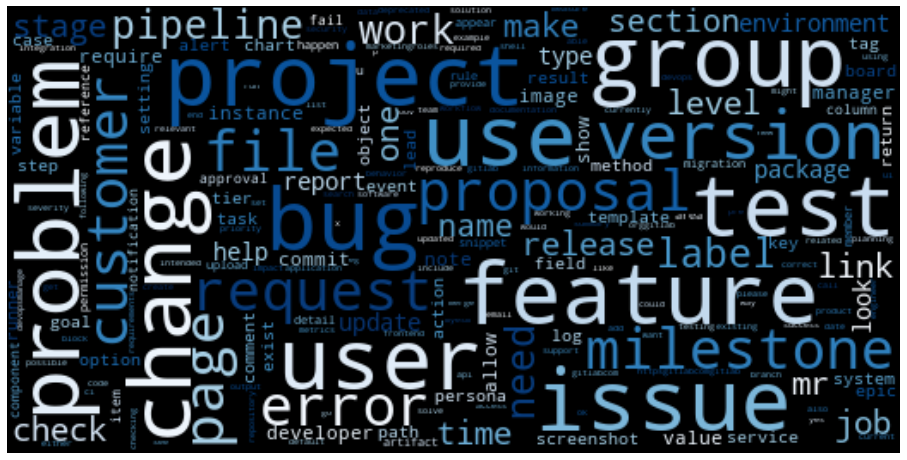

In [169]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

words = list(word_index.keys())[0:num_words]

print(words)

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

msg_text = " ".join(words)

msg_cloud = WordCloud(width = 520, height = 260, stopwords=stop_words,max_font_size=50, background_color ="black", colormap='Blues').generate(msg_text)
plt.figure(figsize=(16,10))
plt.imshow(msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

In [176]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words+1, 32, mask_zero=True, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(label_count + 1, activation='sigmoid')
])


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2, restore_best_weights=True)

num_epochs = 100

history = model.fit(training_sequences, training_labels, epochs=num_epochs, callbacks=[early_stop], validation_data=(test_sequences, test_labels), verbose=2)

print("Training complete!")

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 2048, 32)          32800     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               49664     
_________________________________________________________________
dense_46 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_47 (Dense)             (None, 47)                3055      
Total params: 93,775
Trainable params: 93,775
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1223/1223 - 1693s - loss: 2.9976 - accuracy: 0.1436 - val_loss: 2.3256 - val_accuracy: 0.3414
Epoch 2/100


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

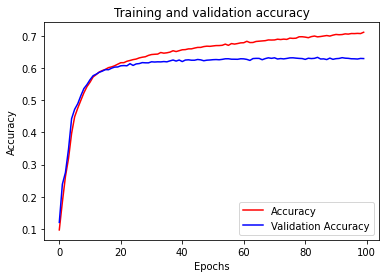

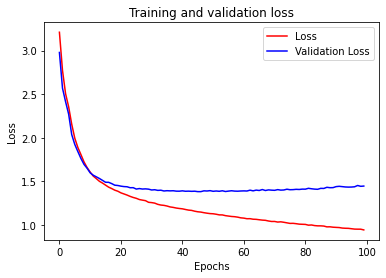

<Figure size 432x288 with 0 Axes>

In [171]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


In [172]:
def predict_group(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen=max_length,
                      padding=padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))

unlabeled_texts = [x.text for x in unlabeled_issues]
print(unlabeled_texts[0])
output = predict_group(unlabeled_texts)
print(output[0])
print(np.argmax(output[0]))
print(output[0][1])

inv_dict = {v: k for k, v in label_word_index.items()} 
index = np.argmax(output[0])
print(inv_dict[index])
print(inv_dict)

error MR approvers edit page Observed gitlabcom worker productionlog Completed Internal Server Error ms ActiveRecord ms worker productionlog worker productionlog ActionViewTemplateError undefined method name nilNilClass worker productionlog ulwell-list worker productionlog - projectapproverseach approver worker productionlog li worker productionlog linkto approverusername approveruser worker productionlog pull-right worker productionlog linkto namespaceprojectapproverpathprojectnamespace project approver data confirm Are sure want remove approver approverusername method delete class btn-xs btn btn-remove title Remove approver worker productionlog iconsign-out worker productionlog appviewsprojectsmergerequestsettingshtmlhamlin block appviewsprojectsmergerequestsettingshtmlhaml999 I checked Rails console project number approvers user ID last one cc sytses vsizov
[5.94539085e-10 1.68552995e-03 6.24567620e-05 3.10133994e-02
 1.73184276e-03 1.11147974e-05 7.71179795e-03 4.54952824e-05
 9.44

In [173]:
for i, result in enumerate(output):
    index = np.argmax(result)
    if index == 0:
        print("unknown: %s" % unlabeled_texts[i][0:100])
        continue
    print("Title: %s -> %s (%f)" % (unlabeled_texts[i][0:100], inv_dict[index], result[index]))
    if i > 100:
        break

Title: error MR approvers edit page Observed gitlabcom worker productionlog Completed Internal Server Error -> group::source_code (0.031013)
Title: Merge request rebase option still performs merge branch names match Rebasing GitLab Were utilizing o -> group::code_review (0.397954)
Title: Sidebar navigation issue viewing Group Settings pages I found interface issue gitlabcom website time -> group::access (0.139498)
Title: install-libs-migrations-etc instructions reversed httpsgitlabcomgitlab-orggitlab-eeblobmasterdocupda -> group::database (0.001857)
Title: Make JIRA service integration flexible We started using Gitlab EE together JIRA We use Gitlab reposi -> group::ecosystem (0.964084)
Title: Merge Requests displays fixes Jira issues When looking merge request indicates messages specific Jir -> group::ecosystem (0.811820)
Title: Issue title alligned issues I noticed gitlabcom Can reproduce locally dev-kit neither master -- stab -> group::project_management (0.066369)
Title: Validate sy

In [144]:
model.save(MODEL_DIR + '/gitlab_issue_classify.h5')
with open(MODEL_DIR + '/label_tokenizer.json', 'w') as file:
    file.write(label_tokenizer.to_json(indent=4, sort_keys=True))
with open(MODEL_DIR + '/text_tokenizer.json', 'w') as file:
    file.write(tokenizer.to_json(indent=4, sort_keys=True))